# Análise de dados: Churn de clientes de banco

Projeto de machine learning para análise de dados e classificação de clientes que potencialmente poderão encerrar suas contas em um banco, os dados estão disponíveis na plataforma [Kaggle](https://www.kaggle.com/datasets/shrutimechlearn/churn-modelling).

O problema a ser solucionado consiste em utilizar os dados bancários dos clientes que efetuaram ou não o encerramento de suas contas para criar um modelo preditivo que irá identificar possíveis clientes que poderão ou não deixar a instituição bancária, podendo assim determinar a taxa de churn (rotatividade/perda de clientes) e com base nos perfis mapeados tomar ações para retenção dos mesmos, evitando impactos como, por exemplo, aumento de custos, queda de lucro, reputação da marca entre outros fatores sensíveis a experiência do cliente com o produto da empresa.

## Demanda da análise

- Analisar a correlação dos dados dos clientes.
- Gerar um modelo preditivo de churn por parte de um cliente.
- Simular novas entradas de dados e previsões.
  
## Tópicos da análise

1. Análise das medidas estatísticas dos dados
2. Distribuição dos dados entre as variáveis independentes (features) e dependente (target)
3. Correlação entre as variáveis
4. Criação do modelo de classificação
   1. Separação dos dados de treino e teste
   2. Treinamento e predições do modelo
   3. Métricas do modelo
   4. Previsões com novos dados
5. Conclusão

## Dicionário de dados

**RowNumber:** Números de linha de 1 a 10.000<br>
**CustomerId:** Ids exclusivos para identificação do cliente do banco<br>
**Surname:** Sobrenome do cliente<br>
**CreditScore:** Score do cliente<br>
**Geography:** País onde o cliente reside<br>
**Gender:** Gênero, masculino ou feminino<br>
**Age:** Idade do cliente<br>
**Tenure:** Número de anos que o cliente está no banco<br>
**Balance:** Saldo bancário do cliente<br>
**NumOfProducts:** Número de produtos bancários que o cliente está utilizando<br>
**HasCrCard:** Flag para saber se o cliente possui um cartão de crédito do banco ou não<br>
**IsActiveMember:** Flag para saber se o cliente é um membro ativo do banco ou não<br>
**EstimatedSalary:** Salário estimado do cliente em dólares<br>
**Exited:** Flag, 1 se o cliente encerrou a conta no banco e 0 se o cliente permaneceu<br>

## Importação de bibliotecas

In [68]:
# Importação de pacotes e definição de parâmetros globais

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc

from sklearn.preprocessing import OneHotEncoder

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')


## Carregamento dos dados

In [69]:
# Efetuando a limpeza de memória antes do carregamento dos dados
gc.collect()

# Caminho do arquivo de dados
path = 'dados/Churn_Modelling.csv'

# Criando um dataframe a partir do arquivo no diretório de dados
df = pd.read_csv(path, encoding='utf-8', sep=',')


## Detalhes do dataframe

In [70]:
# Informações do dataframe como nome das colunas, contagem de
# de dados, tipo de dados e quantidade de memória utilizada

df.info(memory_usage='deep')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 2.6 MB


In [71]:
print('\nQuantidade de linhas (registros): ', df.shape[0])
print('\nQuantidade de colunas (variáveis):', df.shape[1])



Quantidade de linhas (registros):  10000

Quantidade de colunas (variáveis): 14


In [72]:
# Primeiras linhas do dataframe

df.head(10)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


## Removendo colunas que não serão utilizadas

In [73]:
df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])


## Verificando e tratando se necessário registros duplicados

In [74]:
df.duplicated(keep='first').value_counts()


False    10000
dtype: int64

## Verificando e tratando se necessário valores únicos

In [75]:
df.nunique()


CreditScore         460
Geography             3
Gender                2
Age                  70
Tenure               11
Balance            6382
NumOfProducts         4
HasCrCard             2
IsActiveMember        2
EstimatedSalary    9999
Exited                2
dtype: int64

In [76]:
# Verificando a quantidade dos valores únicos de colunas específicas

def exibe_valores_unicos(coluna):
    coluna_qtde = pd.DataFrame(coluna.value_counts().sort_index())
    coluna_qtde = coluna_qtde.T
    print('\n', coluna_qtde)


exibe_valores_unicos(df['Geography'])
exibe_valores_unicos(df['Gender'])
exibe_valores_unicos(df['Tenure'])
exibe_valores_unicos(df['NumOfProducts'])



            France  Germany  Spain
Geography    5014     2509   2477

         Female  Male
Gender    4543  5457

          0     1     2     3    4     5    6     7     8    9    10
Tenure  413  1035  1048  1009  989  1012  967  1028  1025  984  490

                   1     2    3   4
NumOfProducts  5084  4590  266  60


In [77]:
# Transformando valores de algumas colunas em categoria distintas

# Função para transformar valores de colunas em novas categorias
# col: nome da coluna do dataframe
# dict: dicionário de nomes das novas categorias
# df: nome do dataframe

def transforme_coluna(col, dict, df):
    arr = OneHotEncoder().fit_transform(
        col.values.reshape(-1, 1)).toarray()
    df_col = pd.DataFrame(arr)
    df_col.rename(columns=dict, inplace=True)
    df = pd.concat([df, df_col], axis=1)
    return df


dict = {0: 'France', 1: 'Germany', 2: 'Spain'}
df = transforme_coluna(df['Geography'], dict, df)
dict = {0: 'Female', 1: 'Male'}
df = transforme_coluna(df['Gender'], dict, df)

df.head(10)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain,Female,Male
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,0.0,1.0,0.0
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0,1.0,0.0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0,1.0,0.0
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,0.0,1.0,0.0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0,1.0,0.0
5,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1,0.0,0.0,1.0,0.0,1.0
6,822,France,Male,50,7,0.00,2,1,1,10062.80,0,1.0,0.0,0.0,0.0,1.0
7,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1,0.0,1.0,0.0,1.0,0.0
8,501,France,Male,44,4,142051.07,2,0,1,74940.50,0,1.0,0.0,0.0,0.0,1.0
9,684,France,Male,27,2,134603.88,1,1,1,71725.73,0,1.0,0.0,0.0,0.0,1.0


## Verificando e tratando se necessário os tipos de valores

In [78]:
df.dtypes


CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
France             float64
Germany            float64
Spain              float64
Female             float64
Male               float64
dtype: object

In [79]:
# Efetuando as conversões dos tipos de dados

df['France'] = df['France'].astype('int8', errors='ignore')
df['Germany'] = df['Germany'].astype('int8', errors='ignore')
df['Spain'] = df['Spain'].astype('int8', errors='ignore')

df['Female'] = df['Female'].astype('int8', errors='ignore')
df['Male'] = df['Male'].astype('int8', errors='ignore')

df.info(memory_usage='deep')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
 11  France           10000 non-null  int8   
 12  Germany          10000 non-null  int8   
 13  Spain            10000 non-null  int8   
 14  Female           10000 non-null  int8   
 15  Male             10000 non-null  int8   
dtypes: float64(2), int64(7), int8(5), object(2)
memory usage: 1

## Verificando e tratando se necessário valores nulos

In [80]:
df.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
France             0
Germany            0
Spain              0
Female             0
Male               0
dtype: int64

## Amostra de dados do dataframe

In [81]:
df.sample(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain,Female,Male
9629,497,Spain,Male,44,2,121250.04,1,0,1,79691.40,0,0,0,1,0,1
3686,706,France,Male,18,2,176139.50,2,1,0,129654.22,0,1,0,0,0,1
3816,664,France,Female,31,9,114519.57,2,0,1,79222.02,0,1,0,0,1,0
3706,629,Spain,Female,44,6,125512.98,2,0,0,79082.76,0,0,0,1,1,0
7491,622,France,Male,40,4,99799.76,2,1,0,197372.13,0,1,0,0,0,1
6346,551,Germany,Male,50,1,121399.98,1,0,1,84508.44,1,0,1,0,0,1
8121,793,France,Male,35,2,0.00,2,1,1,79704.12,0,1,0,0,0,1
3148,648,France,Female,39,6,130694.89,2,1,1,153955.38,1,1,0,0,1,0
1709,850,Spain,Male,30,2,0.00,2,0,1,27937.12,0,0,0,1,0,1
9636,648,Germany,Female,40,5,139973.65,1,1,1,667.66,1,0,1,0,1,0


## 1. Análise das medidas estatísticas dos dados

In [82]:
# Descrição dos dados estatísticos

df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00
France,10000.0,0.501400,0.500023,0.00,0.00,1.000,1.0000,1.00


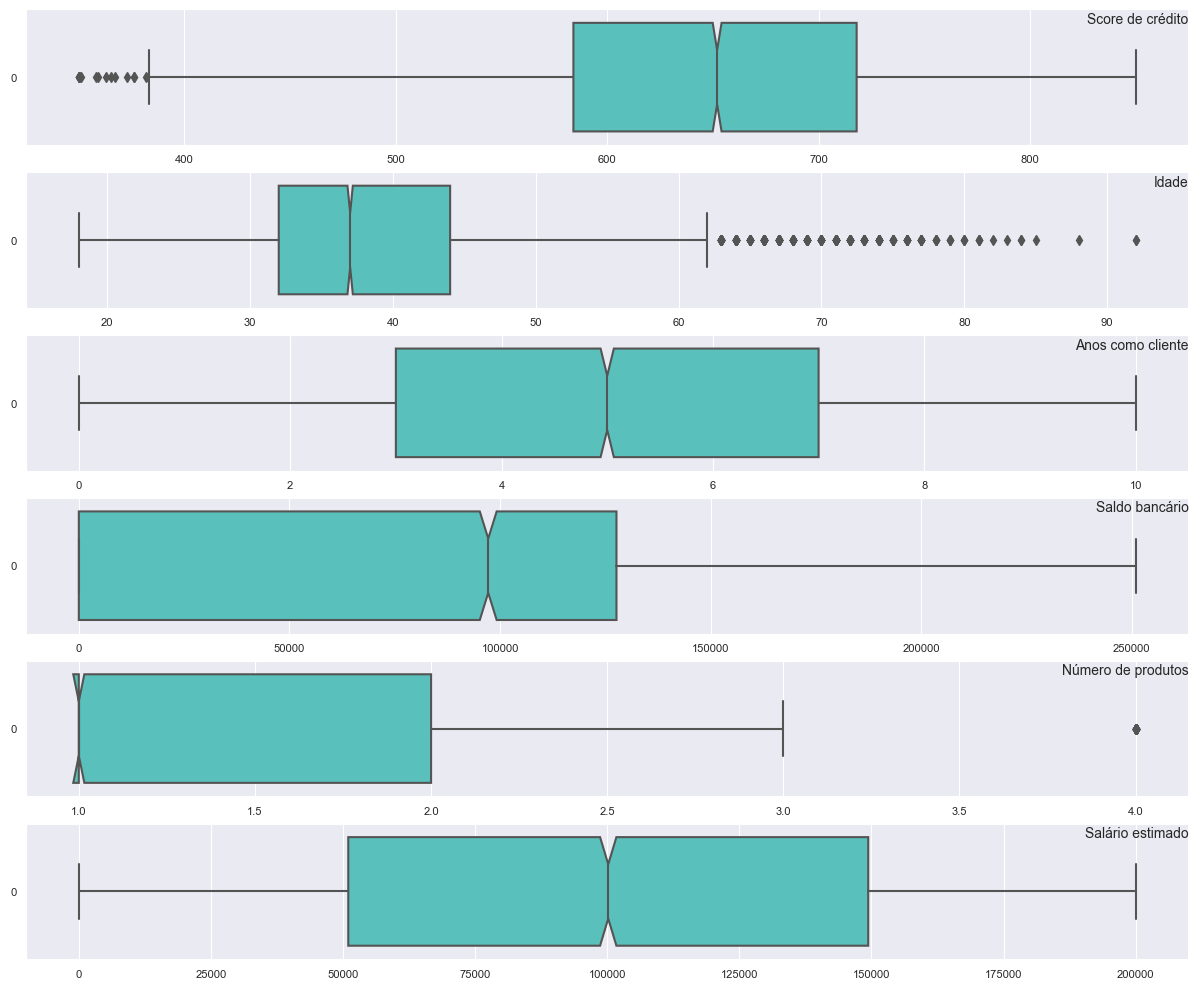


    
Algumas variáveis independentes apresentaram alguns outliers como 'CreditScore'
(Score de crédito) onde há potuações abaixo de aproximadamente 380 , 'Age' (Idade) com
casos atípicos entre 60 e pouco mais de 92 anos e 'NumOfProducts' (Número de produtos)
onde há um grupo de cliente com 4 produtos bancários. Estas situações não significam que
haja algum inconsistência nos dados portanto seram mantidos.     



In [83]:
# Função para geração de gráficos boxplot

def graf_boxplot(coluna, ax, title):
    sns.boxplot(data=coluna, ax=ax, notch=True,
                orient='h', color='mediumturquoise')
    ax.set(xlabel='', ylabel='')
    ax.tick_params(labelsize=8)
    ax.ticklabel_format(style='plain', axis='x')
    ax.set_title(title, loc='right', fontsize=10, pad=-10)


fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(
    nrows=6, ncols=1, figsize=(15, 10))

graf_boxplot(df['CreditScore'], ax1, 'Score de crédito')
graf_boxplot(df['Age'], ax2, 'Idade')
graf_boxplot(df['Tenure'], ax3, 'Anos como cliente')
graf_boxplot(df['Balance'], ax4, 'Saldo bancário')
graf_boxplot(df['NumOfProducts'], ax5, 'Número de produtos')
graf_boxplot(df['EstimatedSalary'], ax6, 'Salário estimado')

plt.subplots_adjust(top=1.9, bottom=0.95)
plt.show()

print('''
    \nAlgumas variáveis independentes apresentaram alguns outliers como 'CreditScore'
(Score de crédito) onde há potuações abaixo de aproximadamente 380 , 'Age' (Idade) com
casos atípicos entre 60 e pouco mais de 92 anos e 'NumOfProducts' (Número de produtos)
onde há um grupo de cliente com 4 produtos bancários. Estas situações não significam que
haja algum inconsistência nos dados portanto seram mantidos.     
''')


## 2. Distribuição dos dados entre as variáveis independentes (features) e dependente (target)

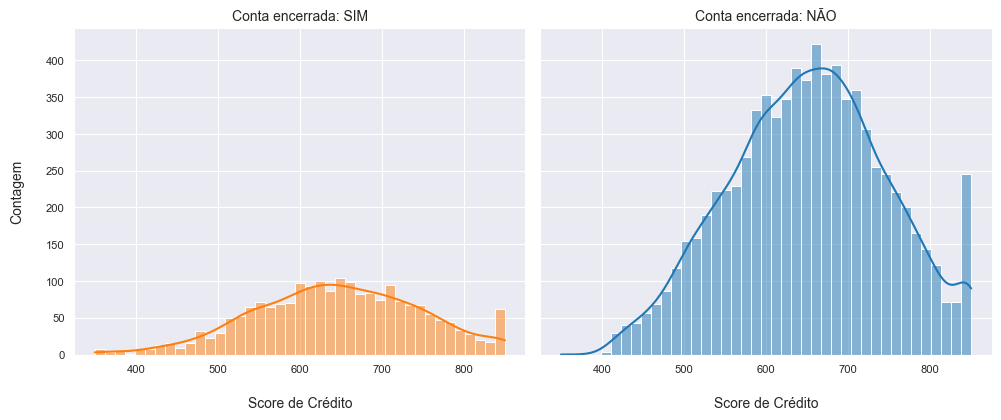

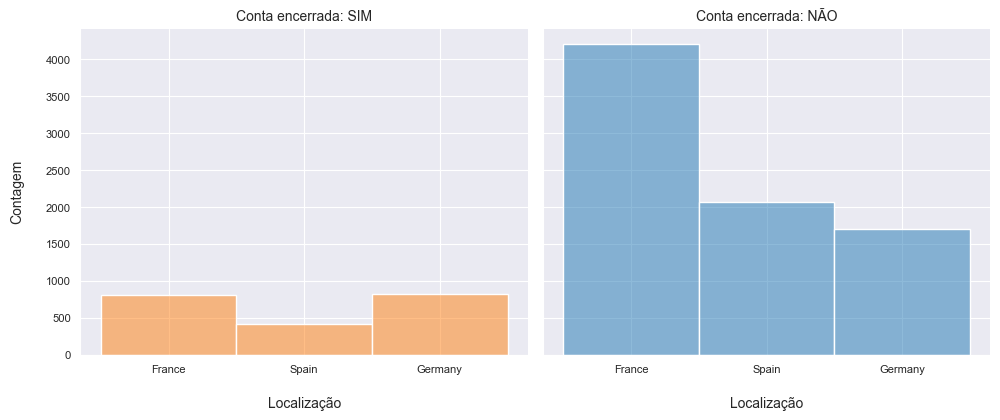

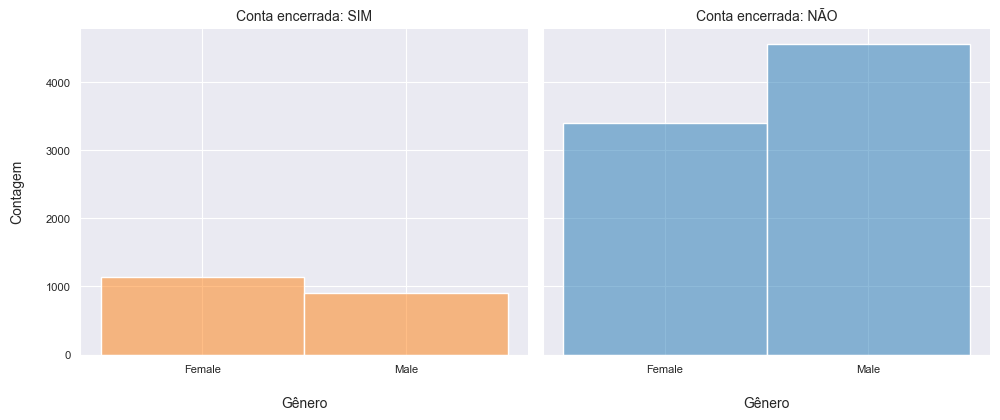

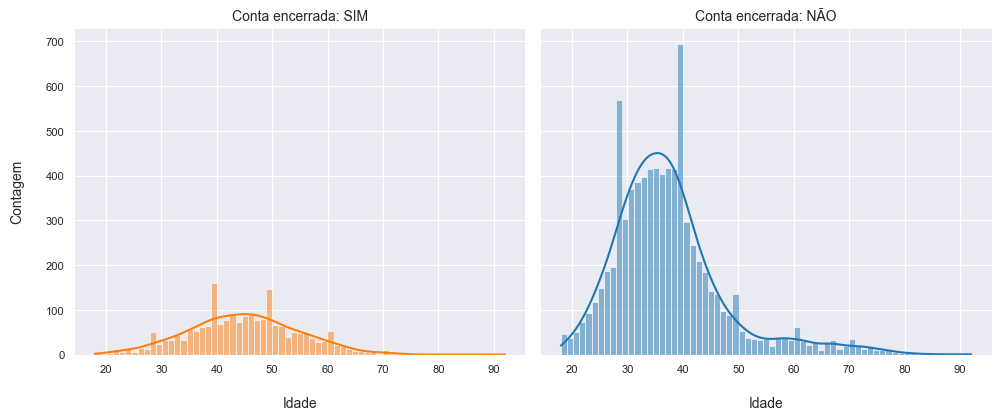

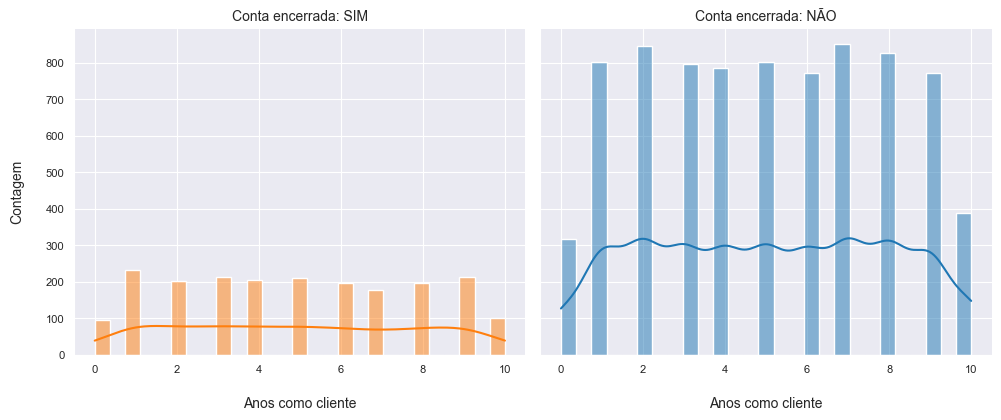

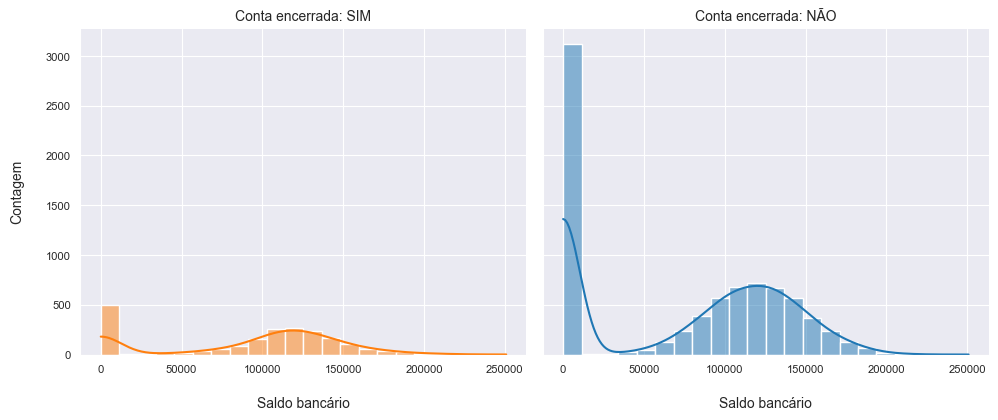

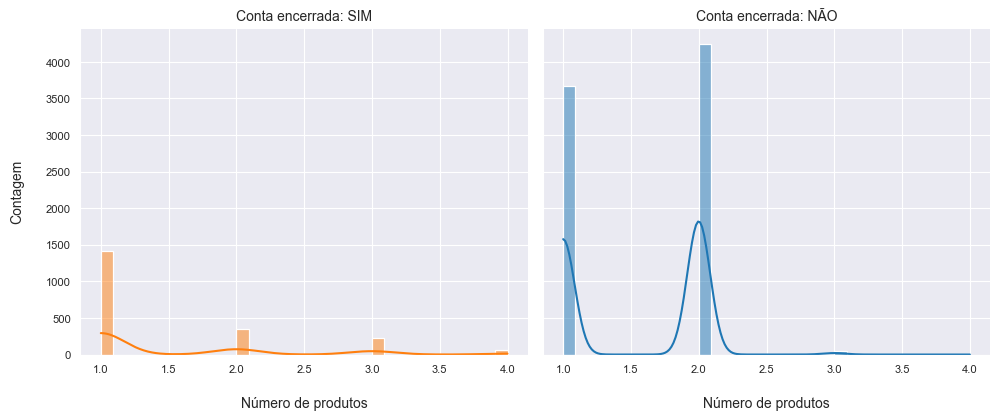

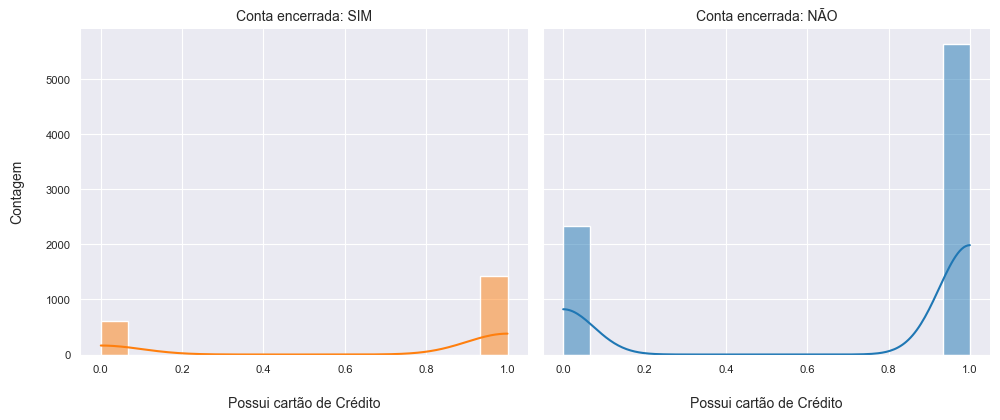

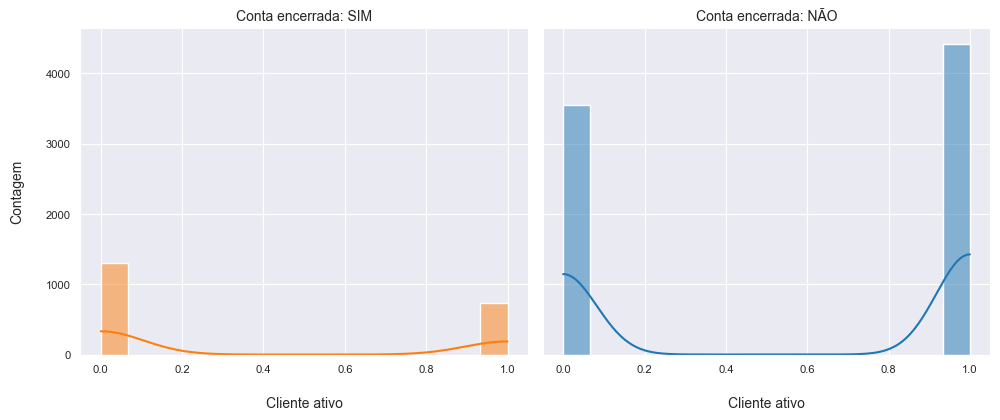

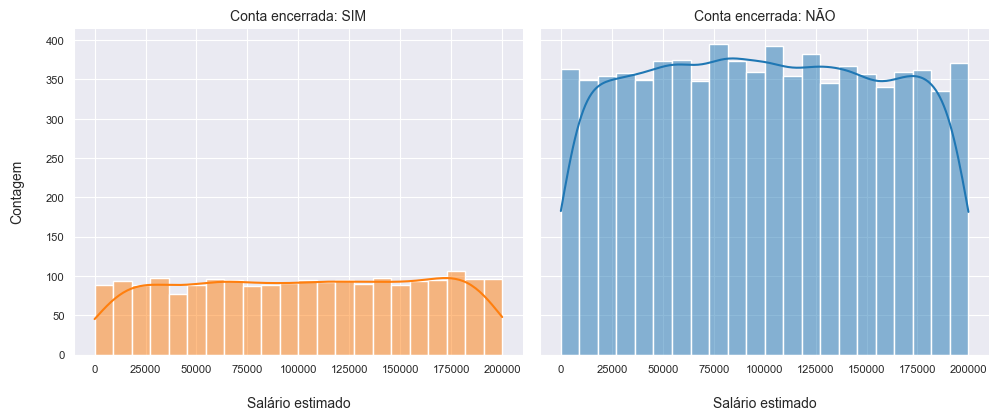

In [98]:
# Função para gerar gráficos displot
# df: dataframe
# x: dados do eixo x
# tilte: título do gráfico
# kde: curva de densidade, default: True

saida = df['Exited'].replace({0: 'NÃO', 1: 'SIM'})
hue_order = ['NÃO', 'SIM']


def graf_displot(df, x, title, kde=True):
    plot = sns.displot(data=df, x=x, col=saida, kde=kde, hue=saida,
                       hue_order=hue_order, legend=False)
    plot.tick_params(labelsize=8)
    plot.set_axis_labels(title, 'Contagem\n', size=10)
    plot.set_titles('Conta encerrada: {col_name}', size=10)
    plot.figure.set_size_inches(10, 4)


graf_displot(df, 'CreditScore', '\nScore de Crédito')
# sns.displot(data=df, x='CreditScore', hue='Exited', col='Exited', kde=True)
graf_displot(df, 'Geography', '\nLocalização', False)
graf_displot(df, 'Gender', '\nGênero', False)
graf_displot(df, 'Age', '\nIdade')
graf_displot(df, 'Tenure', '\nAnos como cliente')
graf_displot(df, 'Balance', '\nSaldo bancário')
graf_displot(df, 'NumOfProducts', '\nNúmero de produtos')
graf_displot(df, 'HasCrCard', '\nPossui cartão de Crédito')
graf_displot(df, 'IsActiveMember', '\nCliente ativo')
graf_displot(df, 'EstimatedSalary', '\nSalário estimado')

plt.show()
